In [32]:
import matplotlib.pyplot as plt
import csv
import numpy
plt.rcParams.update({'font.size': 14})
import seaborn as sns
sns.set_style("darkgrid")

In [33]:
strategy_to_label = dict({
    '-ffproc': 'FastFlowExecutor',
    '-fffarm': 'FastFlow\'s Farm',
    "-processpool": 'concurrent.futures.ProcessPoolExecutor'
})
def plot_csv(filenames, parent_dir = "/", linewidth = 2, colors = ["#A0D2DB", "#188FA7", "#0F5C6B", "#F25A02", "#3F0D12"], save_to=None):
    i = 0
    plot = None
    for filename in filenames:
        plot = plot_one_csv(f"{parent_dir}/{filename}", linewidth, colors[i], plot)
        i = (i+1) % len(colors)
    plt.legend()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()

def plot_one_csv(filename, linewidth = 2, color = "black", plot = None):
    if plot is None:
        fig, axs = plt.subplots(figsize=(18, 5), dpi=300)
        axs.set_xlabel("Number of workers")
        axs.set_ylabel("Time (seconds)")
        plt.title('Time over number of workers', fontweight="bold", y=1.05)
    x_axis = []
    y_axis = []
    with open(filename) as csvfile:  
        plots = csv.reader(csvfile, delimiter = ',')
        next(plots) # skip header of CSV file
        for row in plots:
            workers, n_tasks, ms, bytes, strategy, n_runs, *other = row
            avg_elapsed_time = sum([float(s) for s in other]) / len(other)
            x_axis.append(int(workers))
            y_axis.append(avg_elapsed_time)

    plt.plot(x_axis, y_axis, '-', label=strategy_to_label.get(strategy.strip()), linewidth=linewidth, color=color)[0].set_dash_capstyle('round')

    if plot is None:
        xticks = [1]
        for i in range(5, x_axis[-1], 5):
            xticks.append(i)
        if xticks[-1] != x_axis[-1]:
            xticks.append(x_axis[-1])
            
        plt.xticks(xticks, labels=xticks)
        axs.tick_params(which='minor', length=0)

    #target = [(ms * n_tasks)/i for i in x_axis]
    if plot is None:
        plt.legend()
        return fig, axs
    return plot

def bar_csv(filenames, parent_dir = "/", colors = ["#A0D2DB", "#188FA7", "#0F5C6B", "#F25A02", "#3F0D12"], save_to = None):
    i = 0
    pos = 0
    plot = None
    barwidth = 0.97 / len(filenames)
    for filename in filenames:
        plot = bar_one_csv(f"{parent_dir}/{filename}", pos, barwidth, colors[i], plot=plot)
        i = (i+1) % len(colors)
        pos = pos + 1
    
    _, _, x_data = plot
    plt.xticks([(x + (barwidth*(pos-1))/2) for x in range(len(x_data))], labels=x_data)
    plt.legend()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()

def bar_one_csv(filename, pos, barwidth = 0.4, color = "black", fontsize = 8, plot = None, show_std_dev = False):
    if plot is None:
        fig, axs = plt.subplots(figsize=(18, 5), dpi=300)
        axs.set_xlabel("Number of workers")
        axs.set_ylabel("Time (seconds)")
        plt.title('Time over number of workers', fontweight="bold", y=1.05)
    x_data = []
    y_axis = []
    y_std = []
    with open(filename) as csvfile:  
        plots = csv.reader(csvfile, delimiter = ',')
        next(plots) # skip header of CSV file
        for row in plots:
            workers, n_tasks, ms, bytes, strategy, n_runs, *other = row
            avg_elapsed_time = sum([float(s) for s in other]) / len(other)
            x_data.append(int(workers))
            y_axis.append(avg_elapsed_time)
            y_std.append(numpy.std([float(s) for s in other]))

    x_axis = [i for i in range(len(x_data))]
    bar = plt.bar([i + (barwidth*pos) for i in x_axis], y_axis, barwidth, label=strategy_to_label.get(strategy.strip()), color=color)
    if show_std_dev:
        plt.errorbar([i + (barwidth*pos) for i in x_axis], y_axis, yerr=y_std, fmt='o', elinewidth=3, capsize=0, color="#00000090", ecolor='#00000050')

    # Add counts above the bar graph
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height+(0.002)*height, f'{height:.2f}', ha='center', va='bottom', size=fontsize)
        
    if plot is None:
        plt.legend()
        return fig, axs
    
    return plot, bar, x_data

def plot_scalability_csv(filenames, parent_dir = "/", colors = ["#A0D2DB", "#188FA7", "#0F5C6B", "#F25A02", "#3F0D12"], linewidth = 2, save_to = None):
    fig, axs = plt.subplots(figsize=(18, 5), dpi=300)
    plt.title('Scalability', fontweight="bold", y=1.05)
    axs.set_xlabel("Number of workers")
    axs.set_ylabel("Scalability")
    for i, filename in enumerate(filenames):
        x_axis = []
        y_axis = []
        with_one_worker = 0
        with open(f"{parent_dir}/{filename}") as csvfile:  
            plots = csv.reader(csvfile, delimiter = ',')
            next(plots) # skip header of CSV file
            for row in plots:
                workers, n_tasks, ms, bytes, strategy, n_runs, *other = row
                avg_elapsed_time = sum([float(s) for s in other]) / len(other)
                x_axis.append(int(workers))
                if int(workers) == 1:
                    with_one_worker = avg_elapsed_time
                y_axis.append(with_one_worker/avg_elapsed_time)
            plt.plot(x_axis, y_axis, '-', label=strategy_to_label.get(strategy.strip()), linewidth=linewidth, color=colors[i % len(colors)])[0].set_dash_capstyle('round')
    
    plt.plot(x_axis, [nw for nw in x_axis], ls="dotted", label="Ideal", linewidth=linewidth, color="black")[0].set_dash_capstyle('round')

    xticks = [1]
    for i in range(5, x_axis[-1], 5):
        xticks.append(i)
    if xticks[-1] != x_axis[-1]:
        xticks.append(x_axis[-1])
        
    plt.xticks(xticks, labels=xticks)
    axs.tick_params(which='minor', length=0)

    plt.legend()
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")
    plt.show()

In [34]:
parent_dir = "/mnt/Data/github/fastflow-python/benchmarks"

In [35]:
#plot_csv(["512_1000.processpool.csv", "512_1000.fastflow.csv", "512_1000.farm.csv"], parent_dir, save_to='512_1000_plot.png')
#bar_csv(["512_1000.processpool.csv", "512_1000.fastflow.csv", "512_1000.farm.csv"], parent_dir, save_to='512_1000_bar.png')

In [36]:
#plot_csv(["512_500.processpool.csv", "512_500.fastflow.csv", "512_500.farm.csv"], parent_dir, save_to='512_500_plot.png')
#bar_csv(["512_500.processpool.csv", "512_500.fastflow.csv", "512_500.farm.csv"], parent_dir, save_to='512_500_bar.png')

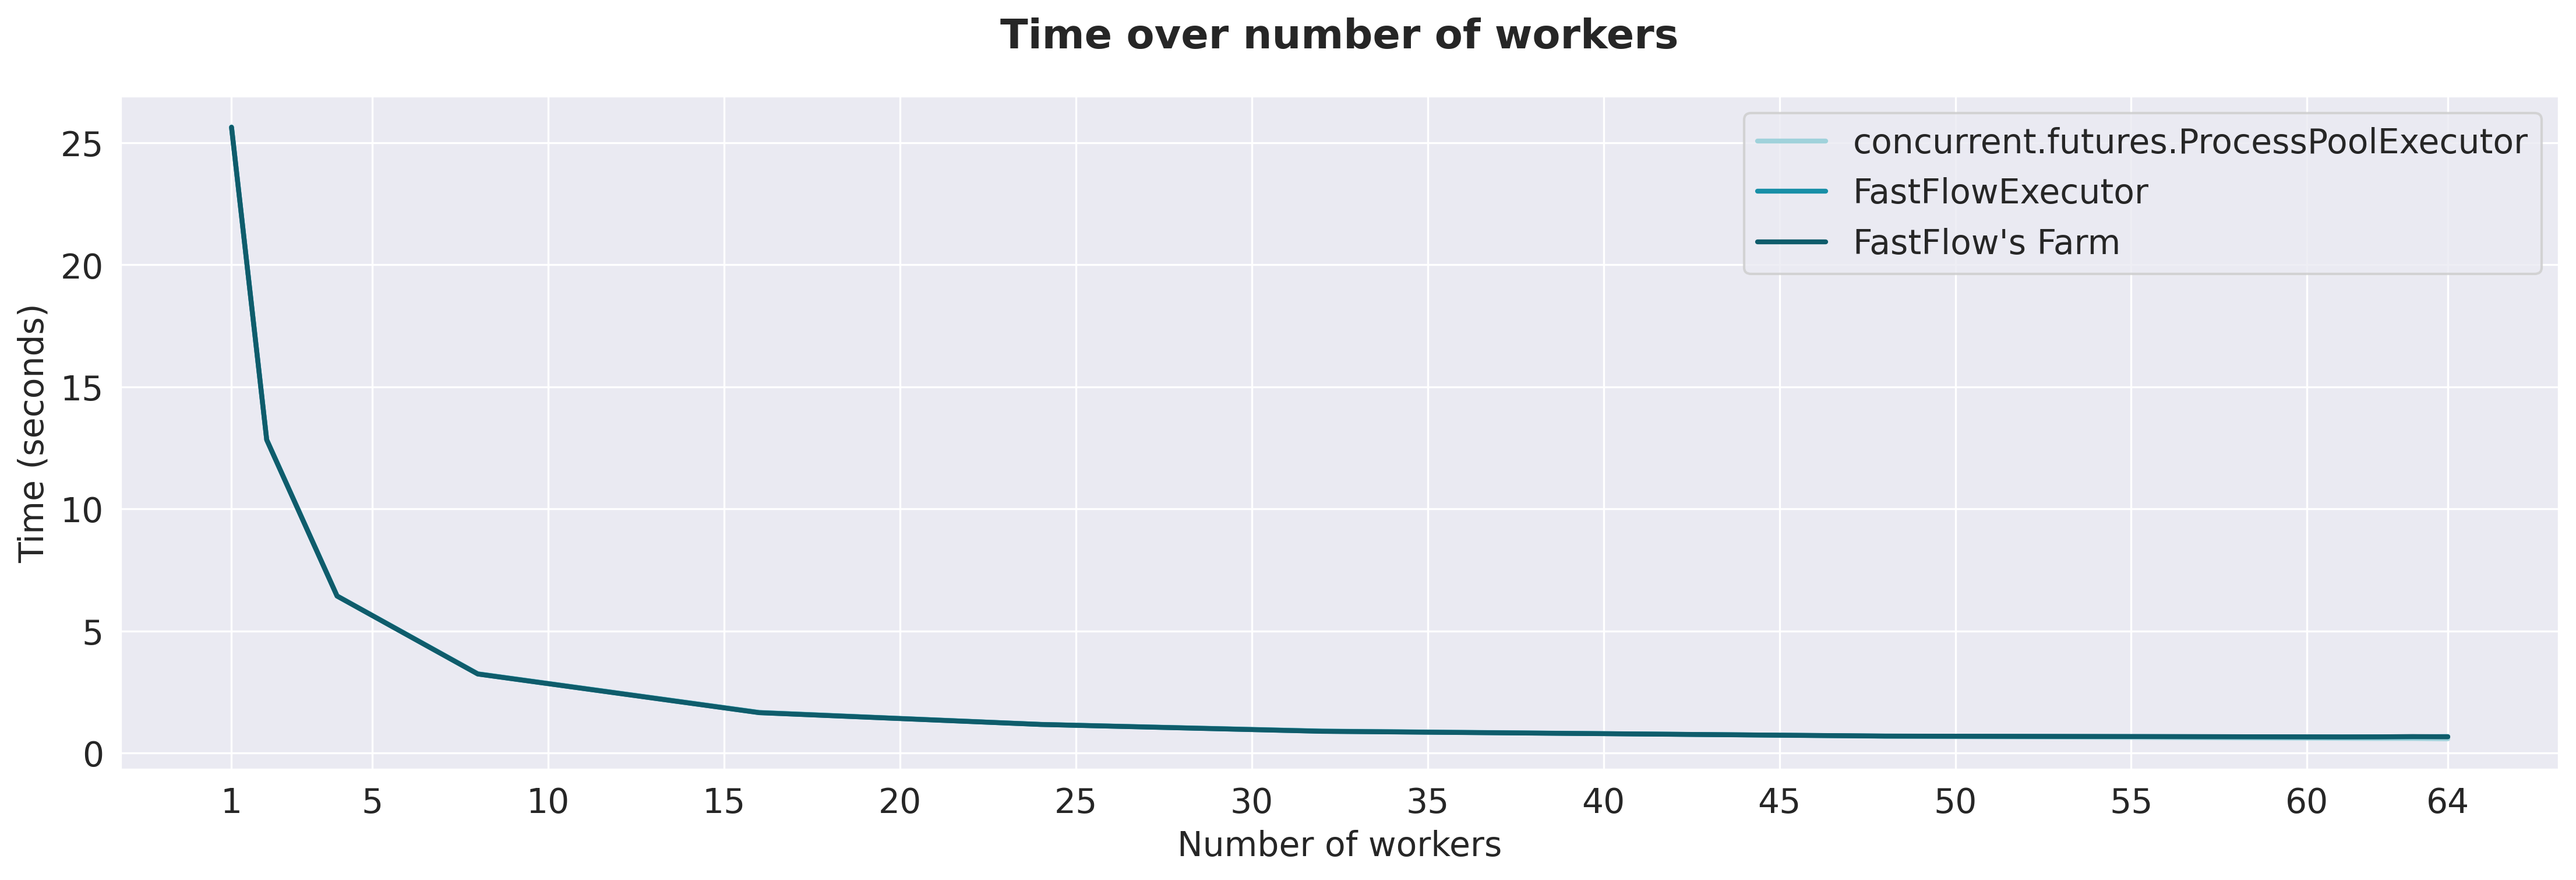

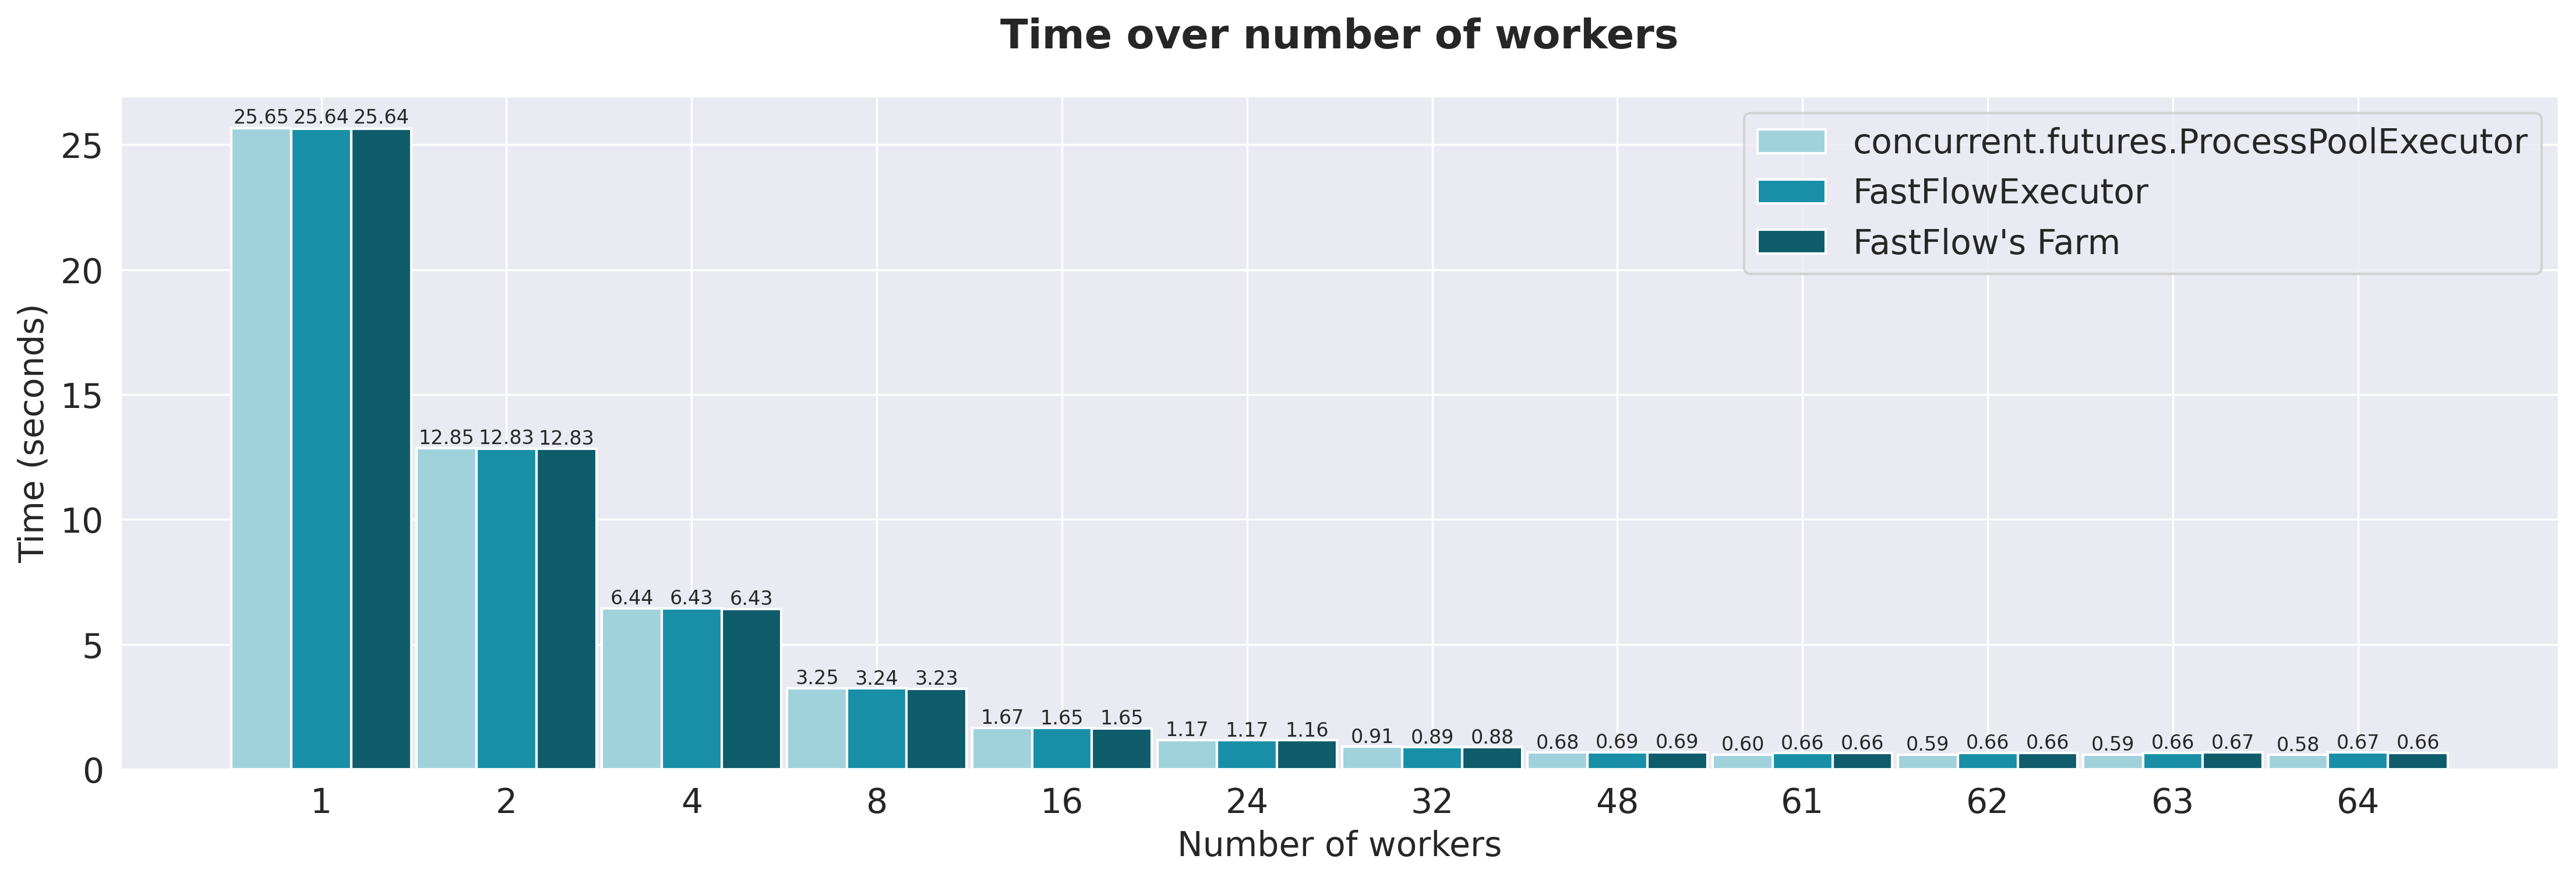

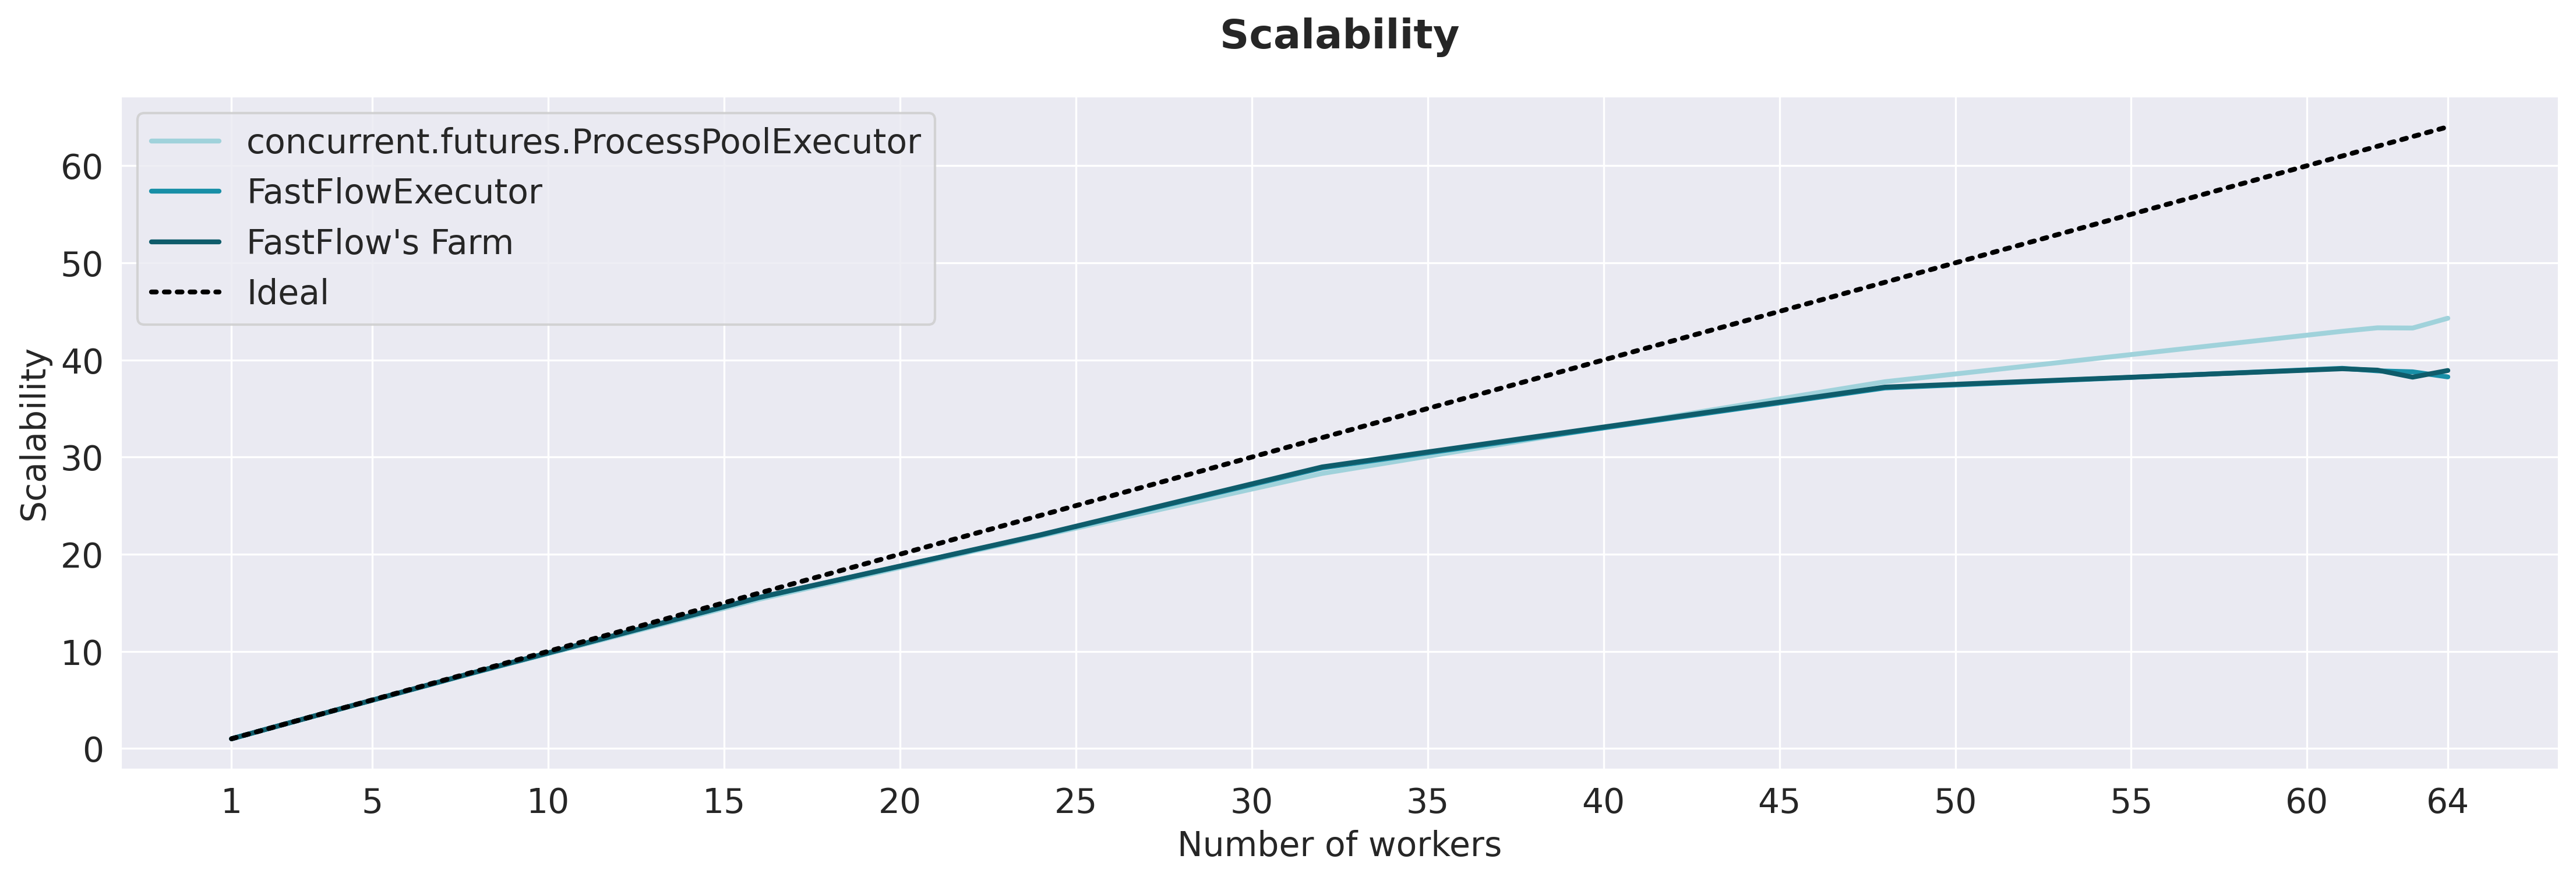

In [37]:
plot_csv(["512_50.processpool.csv", "512_50.fastflow.csv", "512_50.farm.csv"], parent_dir, save_to='512_50_plot.png')
bar_csv(["512_50.processpool.csv", "512_50.fastflow.csv", "512_50.farm.csv"], parent_dir, save_to='512_50_bar.png')
plot_scalability_csv(["512_50.processpool.csv", "512_50.fastflow.csv", "512_50.farm.csv"], parent_dir, save_to='512_50_scalability.png')

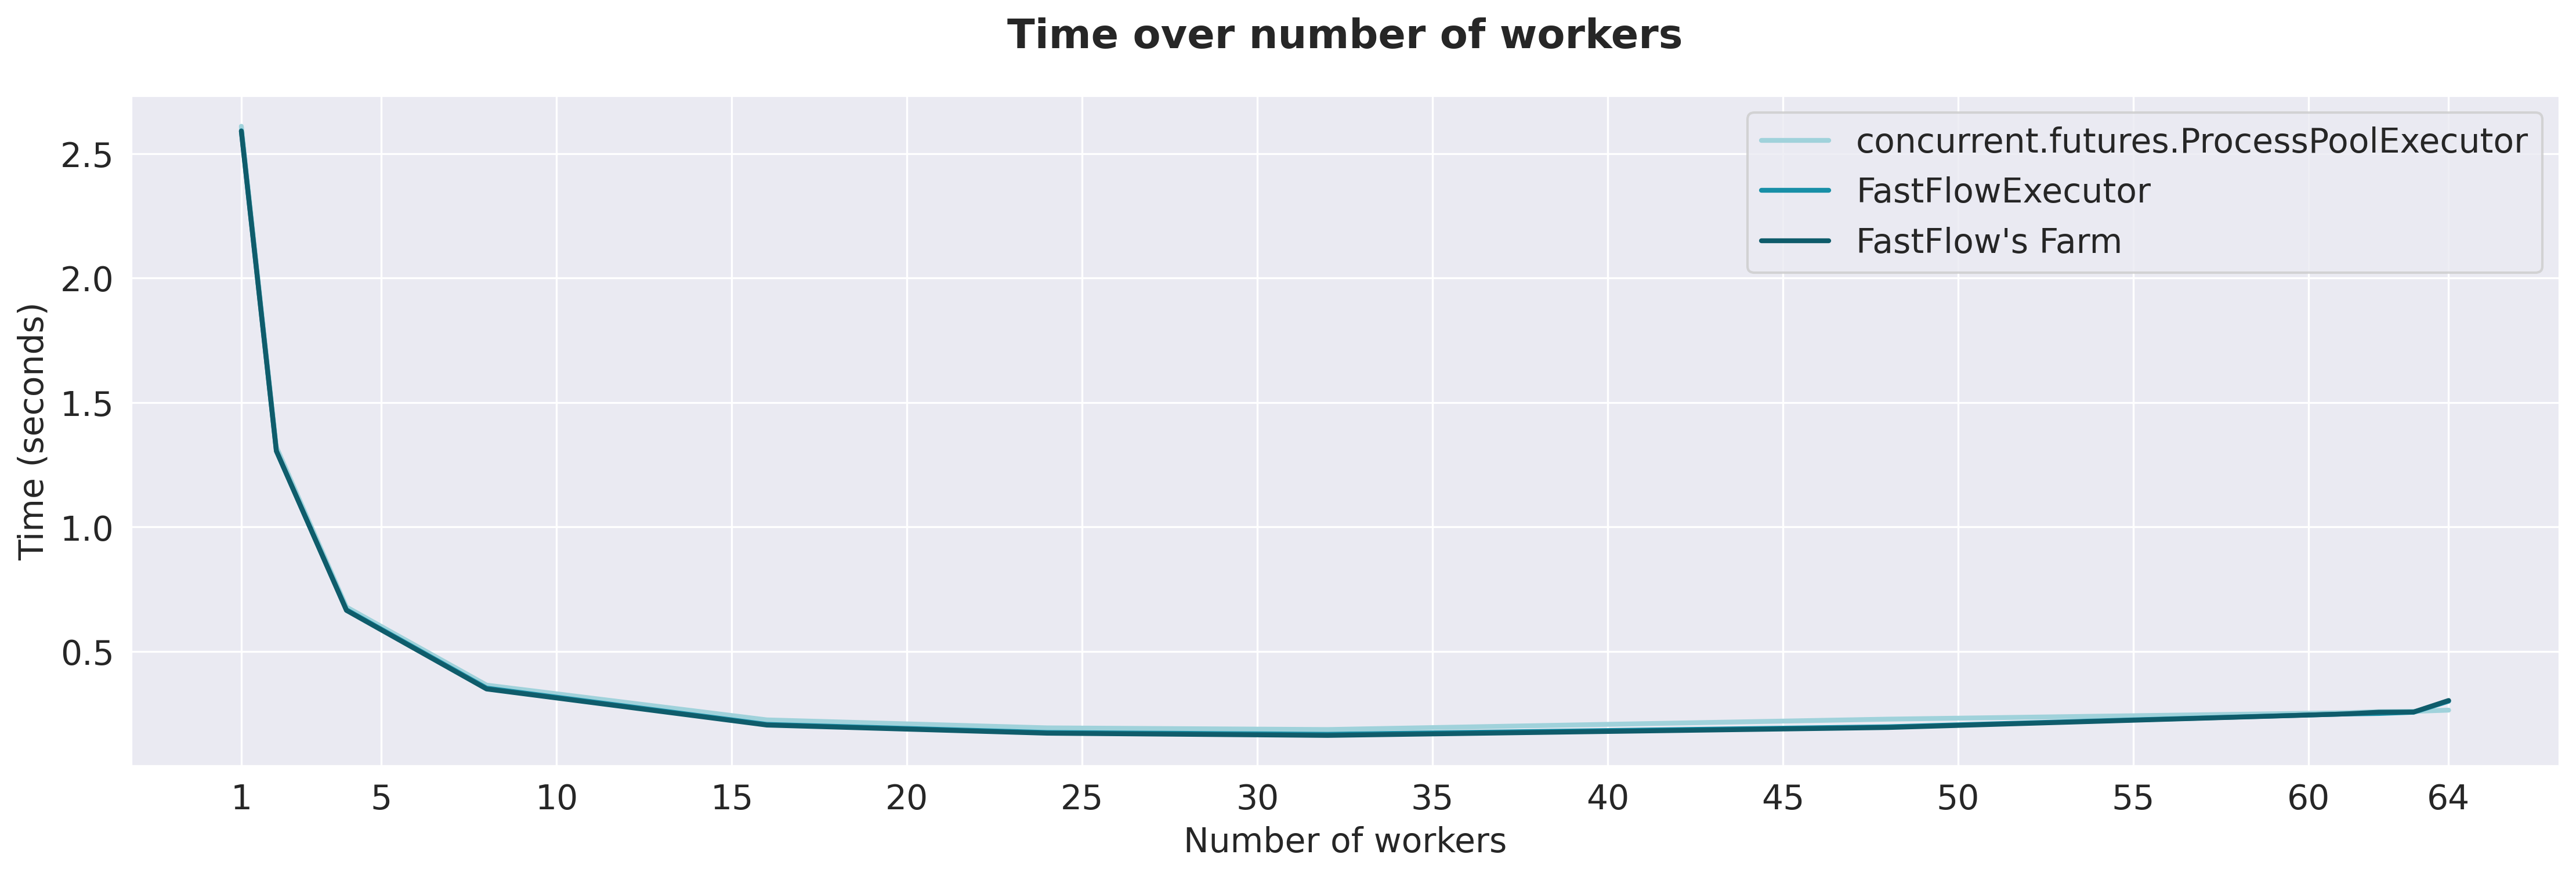

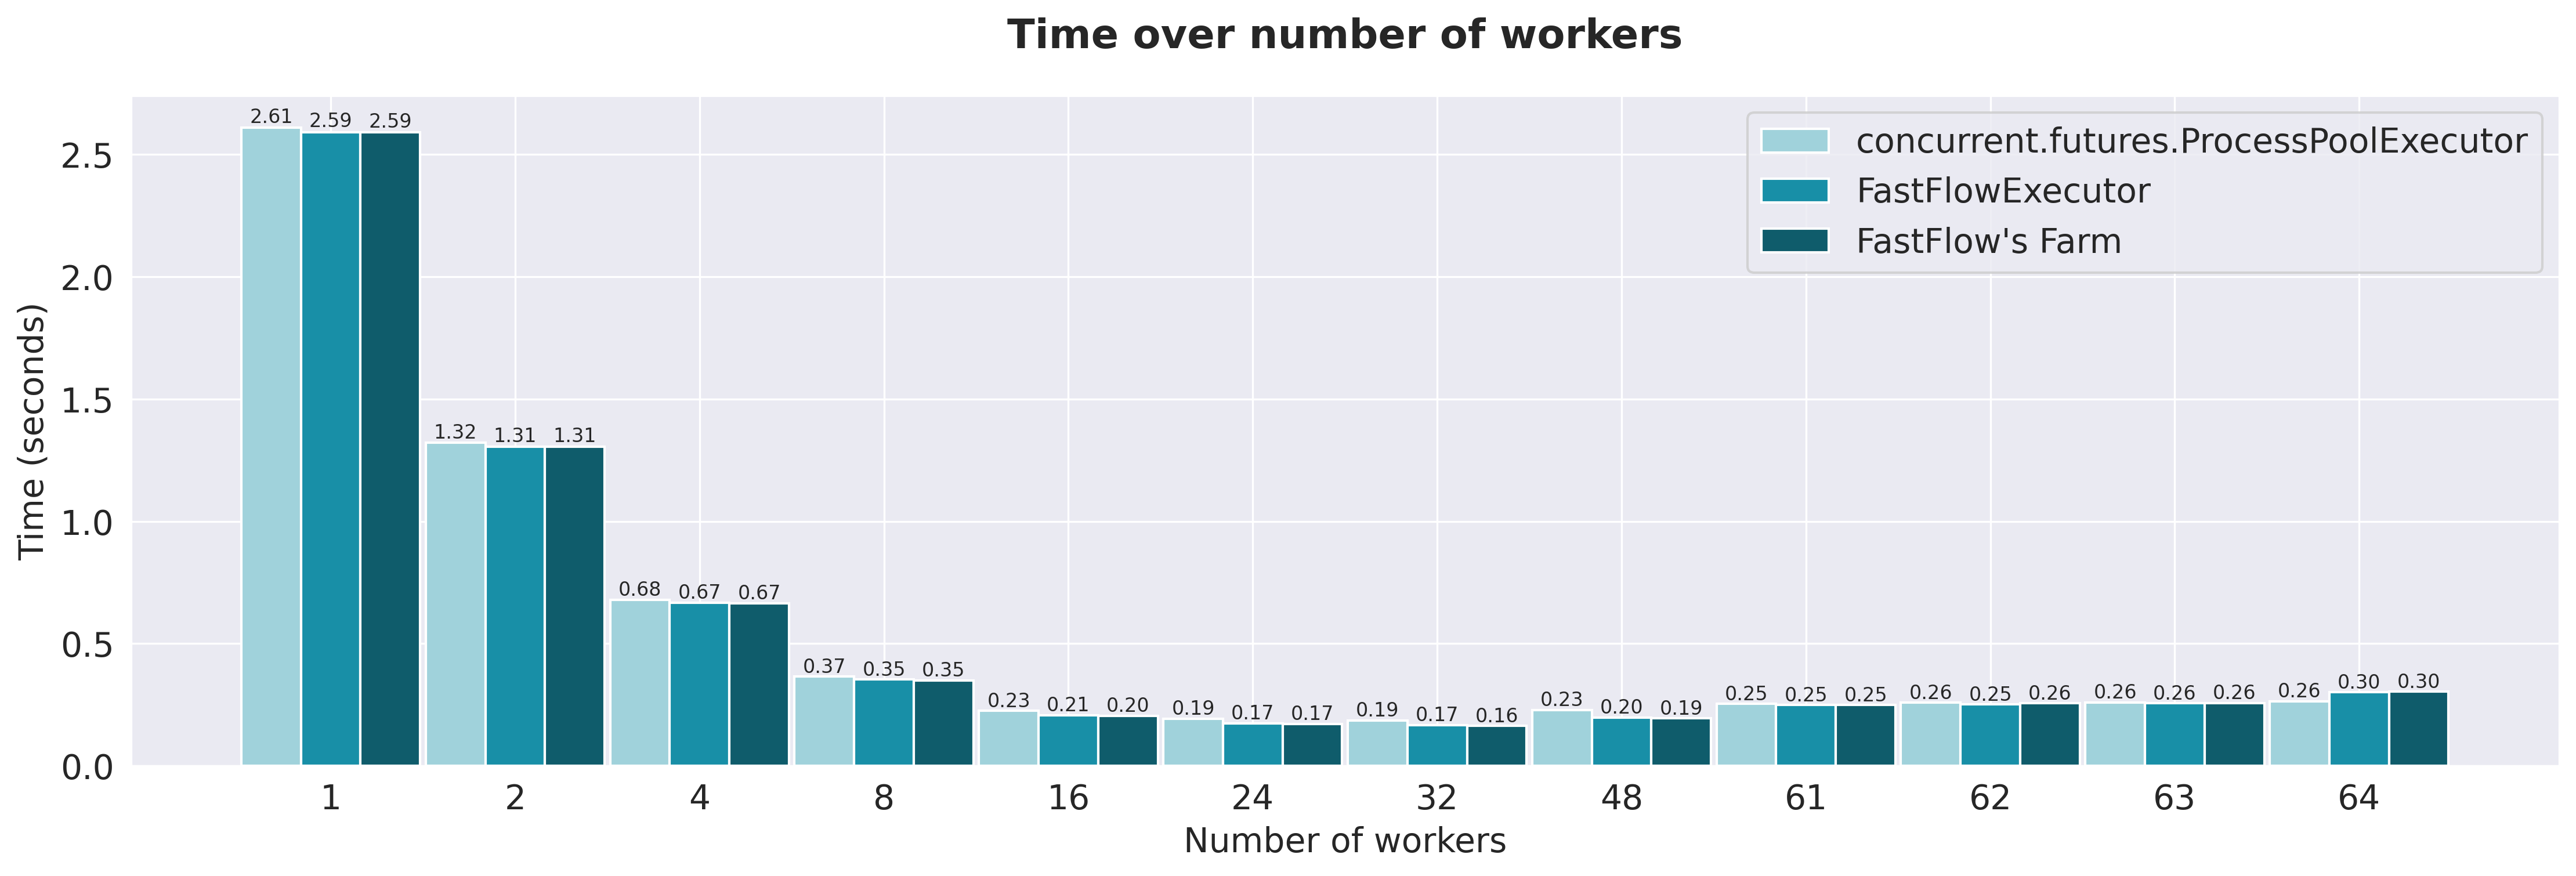

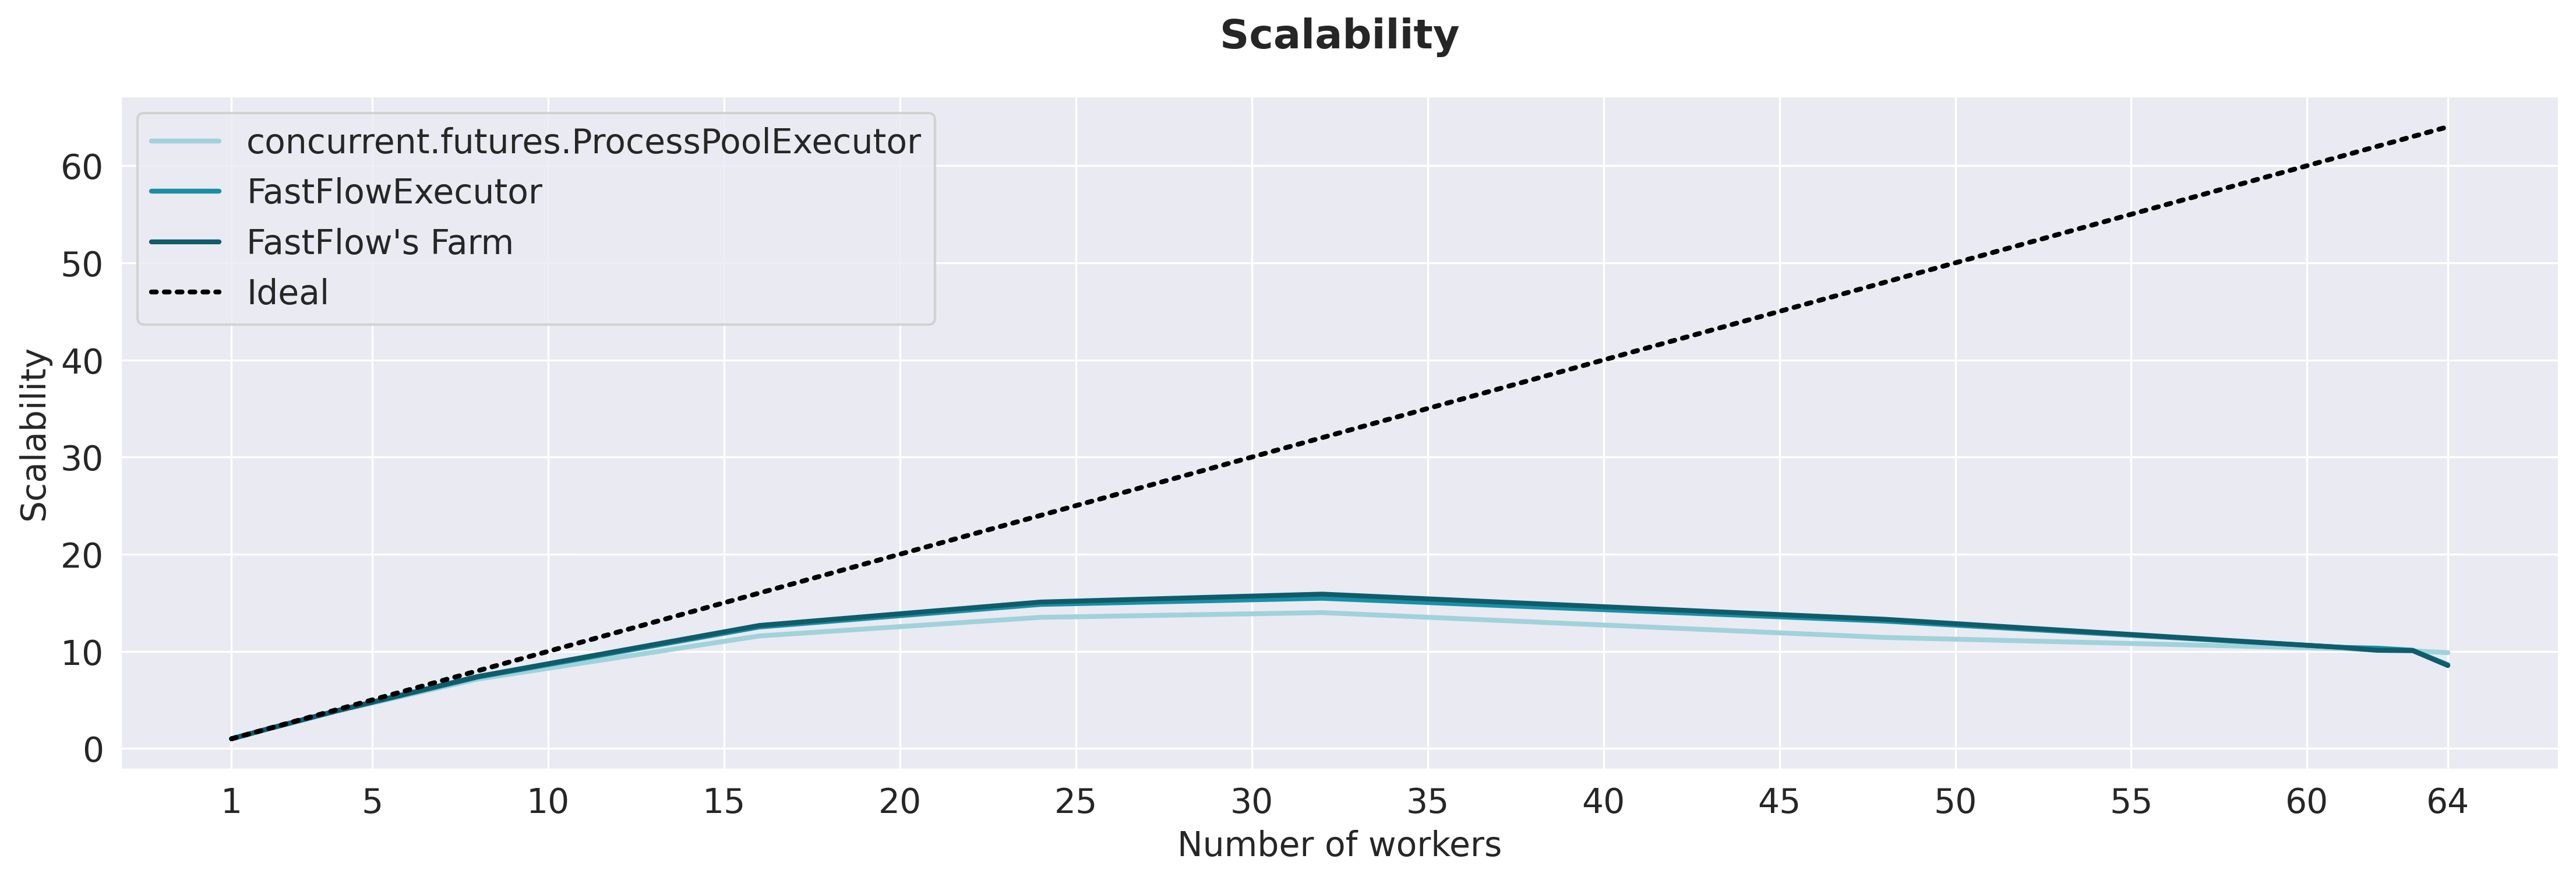

In [38]:
plot_csv(["512_5.processpool.csv", "512_5.fastflow.csv", "512_5.farm.csv"], parent_dir, save_to='512_5_plot.png')
bar_csv(["512_5.processpool.csv", "512_5.fastflow.csv", "512_5.farm.csv"], parent_dir, save_to='512_5_bar.png')
plot_scalability_csv(["512_5.processpool.csv", "512_5.fastflow.csv", "512_5.farm.csv"], parent_dir, save_to='512_5_scalability.png')

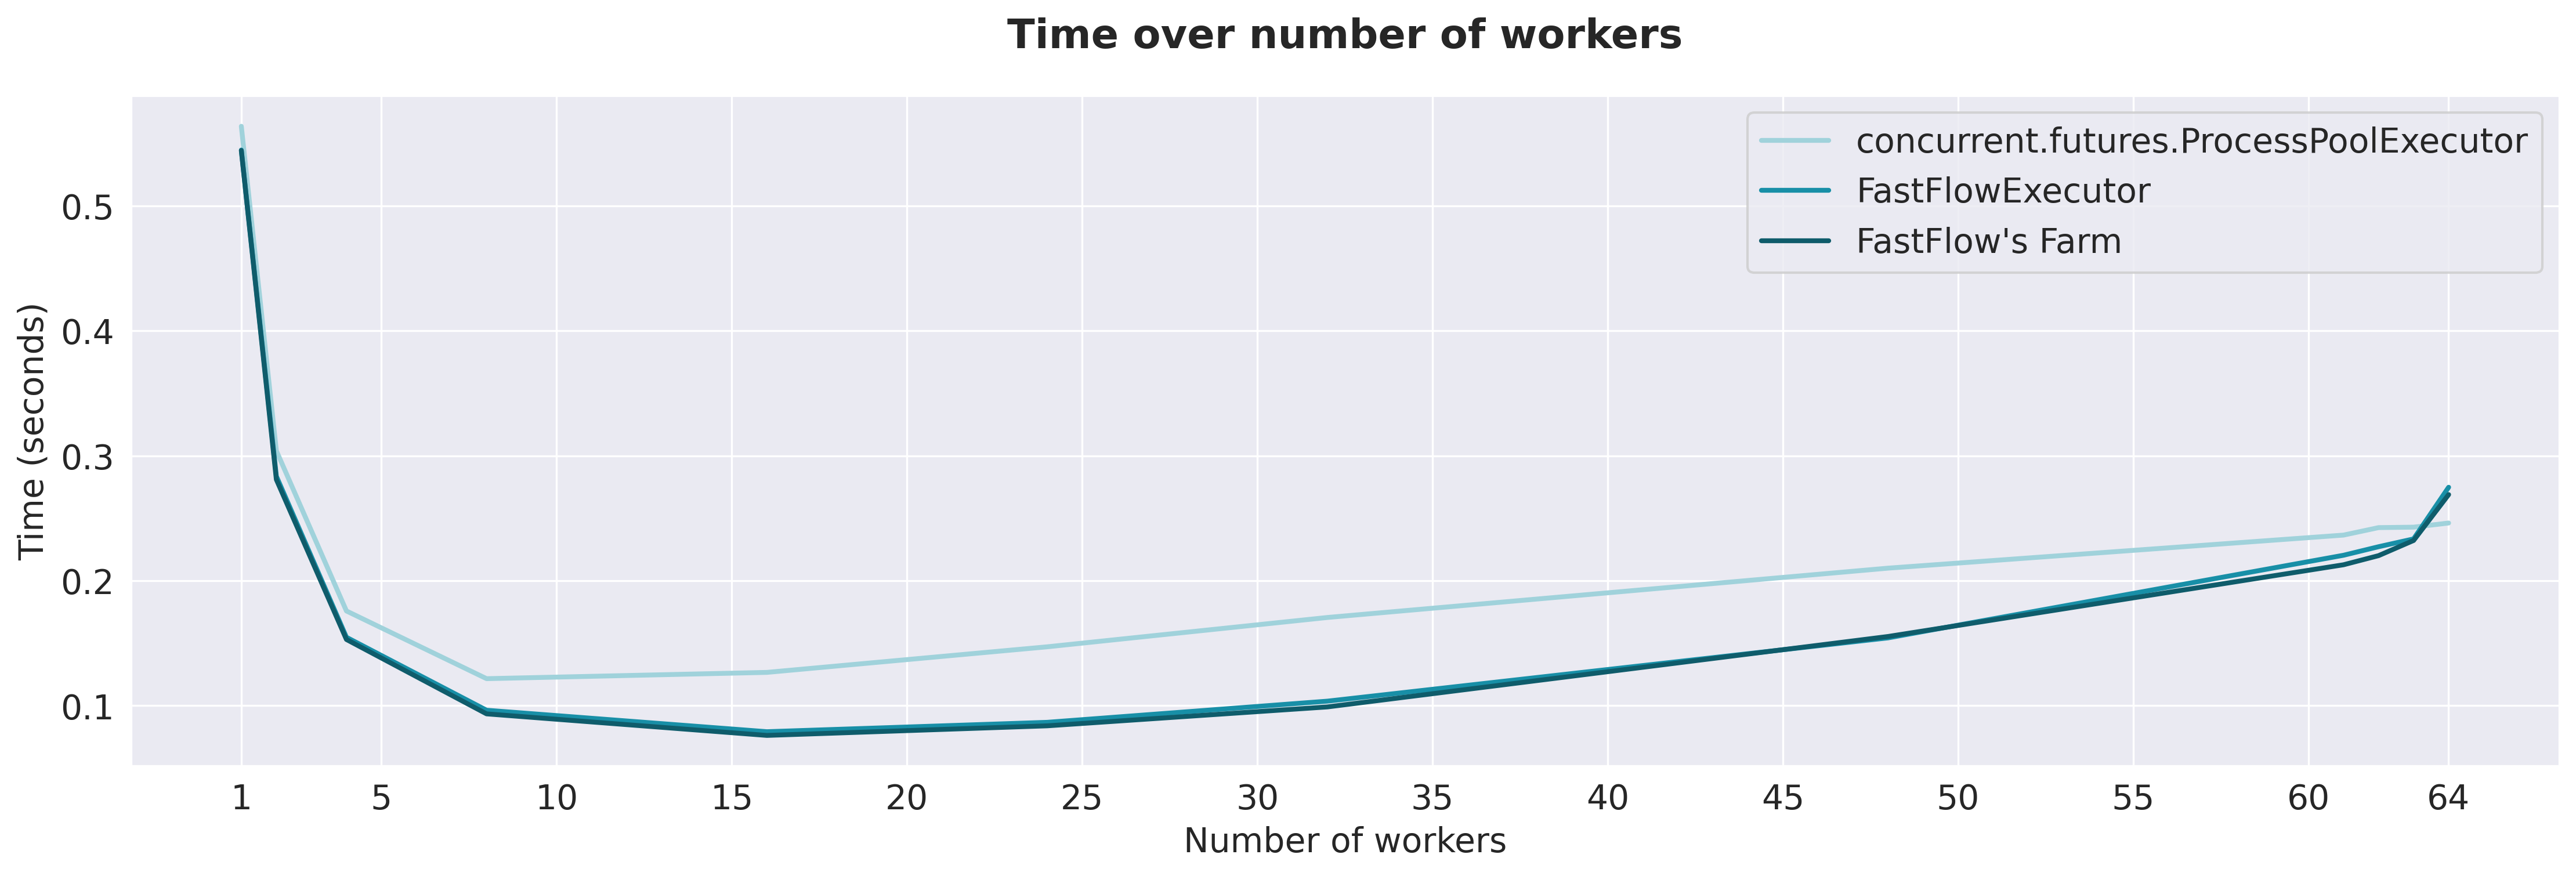

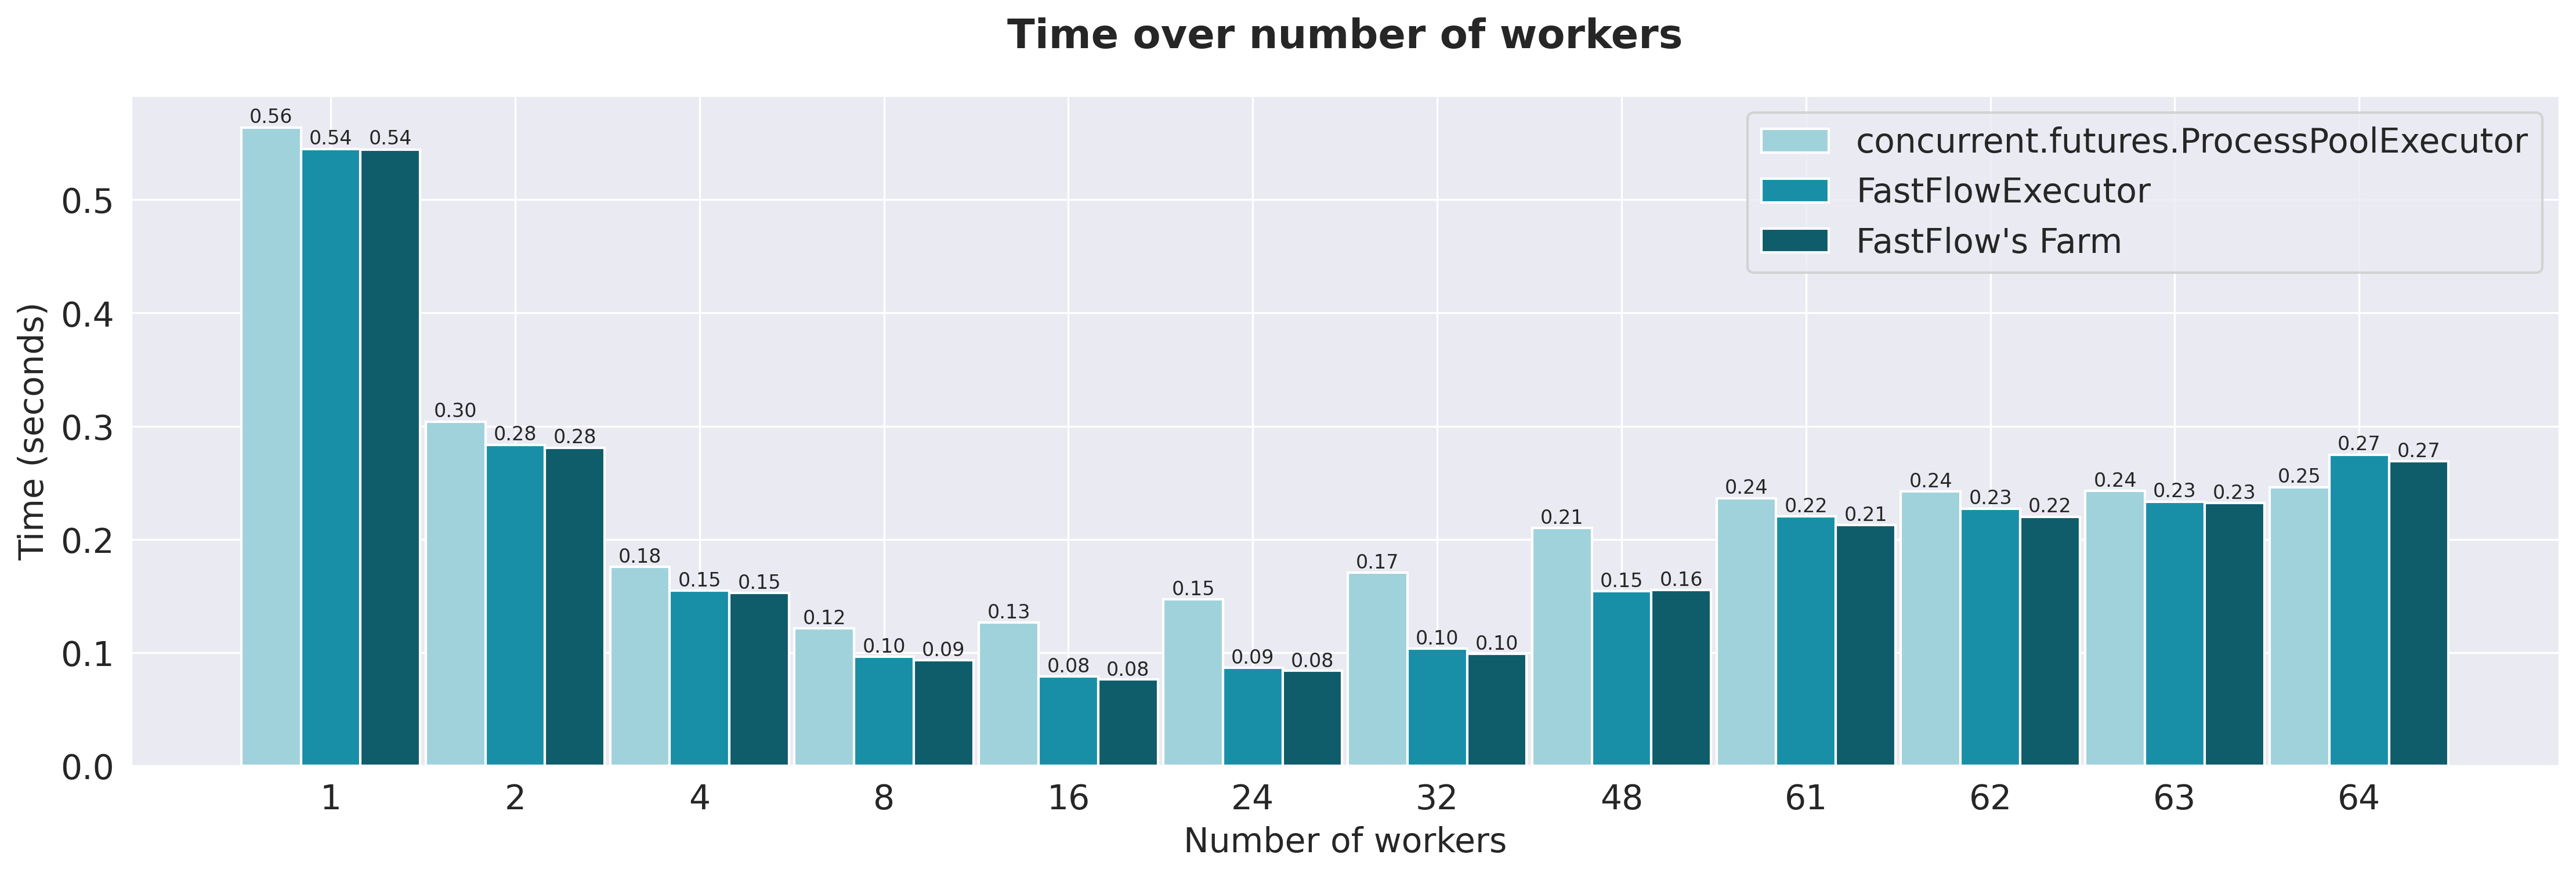

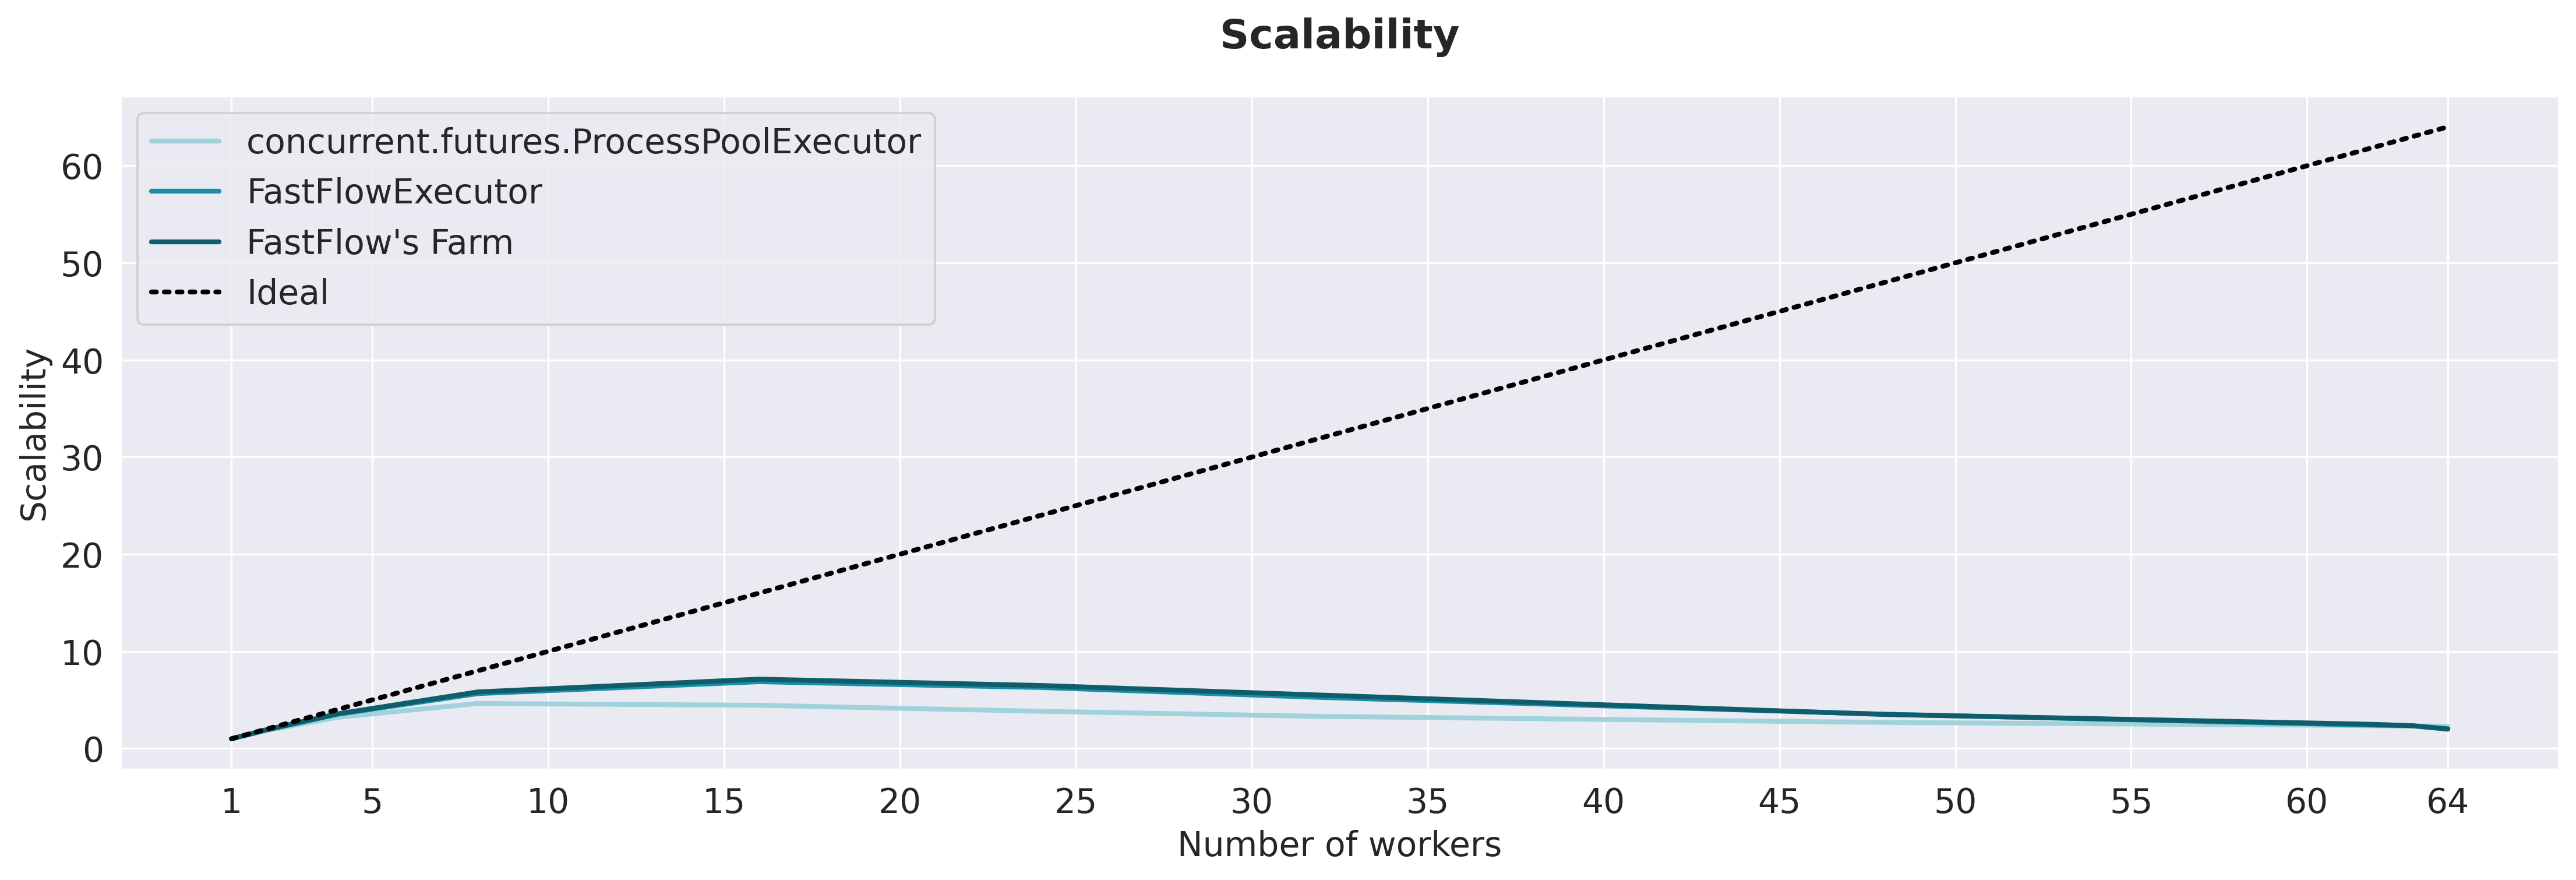

In [39]:
plot_csv(["512_1.processpool.csv", "512_1.fastflow.csv", "512_1.farm.csv"], parent_dir, save_to='512_1_plot.png')
bar_csv(["512_1.processpool.csv", "512_1.fastflow.csv", "512_1.farm.csv"], parent_dir, save_to='512_1_bar.png')
plot_scalability_csv(["512_1.processpool.csv", "512_1.fastflow.csv", "512_1.farm.csv"], parent_dir, save_to='512_1_scalability.png')